# **Pratical 1**

In [1]:
import zipfile
import numpy as np
import matplotlib.pyplot as plt
import csv
import numpy as np
from numba import njit, prange

In [3]:
!wget https://files.grouplens.org/datasets/movielens/ml-32m.zip

--2025-11-24 11:04:48--  https://files.grouplens.org/datasets/movielens/ml-32m.zip
Resolving files.grouplens.org (files.grouplens.org)... 128.101.96.204
Connecting to files.grouplens.org (files.grouplens.org)|128.101.96.204|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 238950008 (228M) [application/zip]
Saving to: ‘ml-32m.zip’

ml-32m.zip          100%[===================>] 227.88M  3.46MB/s    in 56s     

2025-11-24 11:05:45 (4.06 MB/s) - ‘ml-32m.zip’ saved [238950008/238950008]



In [4]:
# Unzip the downloaded file
with zipfile.ZipFile('ml-32m.zip', 'r') as zip_ref:
    zip_ref.extractall('.')

In [5]:
userid_to_idx = {}
idx_to_user =  []
movieid_to_idx = {}
idx_to_movie = []
data_by_user = []
data_by_movie = []

# Optimisation of data structure

In [6]:
with open('ml-32m/ratings.csv', mode='r', newline='') as file:
    csv_reader = csv.reader(file)
    next(csv_reader)

    for row in csv_reader:
        user_id = int(row[0])
        movie_id = int(row[1])
        ranking_value = float(row[2])

        if user_id not in userid_to_idx:
            userid_to_idx[user_id] = len(userid_to_idx)
            idx_to_user.append(user_id)
            data_by_user.append([])

        if movie_id not in movieid_to_idx:
            movieid_to_idx[movie_id] = len(movieid_to_idx)
            idx_to_movie.append(movie_id)
            data_by_movie.append([])

        prov_user_key = userid_to_idx[user_id]
        prov_movie_key = movieid_to_idx[movie_id]
        data_by_user[prov_user_key].append((prov_movie_key,float(row[2])))
        data_by_movie[prov_movie_key].append((prov_user_key,float(row[2])))

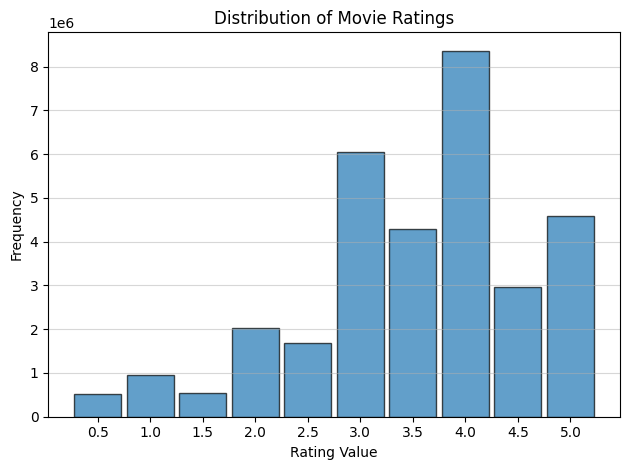

In [7]:
ratings = np.array([float(rating_value) for user_data in data_by_user for _, rating_value in user_data])
bins = np.arange(0.25, 5.5, 0.5)

counts, _, patches = plt.hist(ratings, bins=bins, edgecolor='black', alpha=0.7, rwidth=0.9)

plt.title('Distribution of Movie Ratings')
plt.xlabel('Rating Value')
plt.ylabel('Frequency')
plt.xticks(np.arange(0.5, 5.5, 0.5))
plt.grid(axis='y', alpha=0.5)
plt.tight_layout()
plt.savefig(
    "rating_distribution.pdf",
    format="pdf"
)
plt.show()

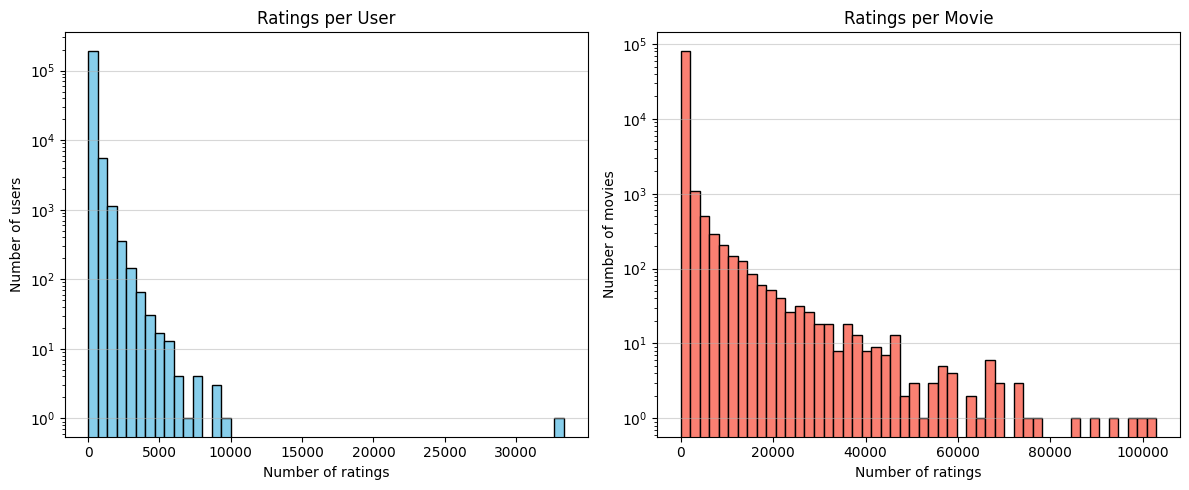

In [8]:
ratings_per_user = [len(user_data) for user_data in data_by_user]
ratings_per_item = [len(item_data) for item_data in data_by_movie]

plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.hist(ratings_per_user, bins=50, color='skyblue', edgecolor='black')
plt.title("Ratings per User")
plt.xlabel("Number of ratings")
plt.ylabel("Number of users")
plt.yscale('log')
plt.grid(axis='y', alpha=0.5)

plt.subplot(1,2,2)
plt.hist(ratings_per_item, bins=50, color='salmon', edgecolor='black')
plt.title("Ratings per Movie")
plt.xlabel("Number of ratings")
plt.ylabel("Number of movies")
plt.yscale('log')
plt.grid(axis='y', alpha=0.5)
plt.savefig(
    "rating_by_user_movie.pdf",
    format="pdf"
)
plt.tight_layout()
plt.show()

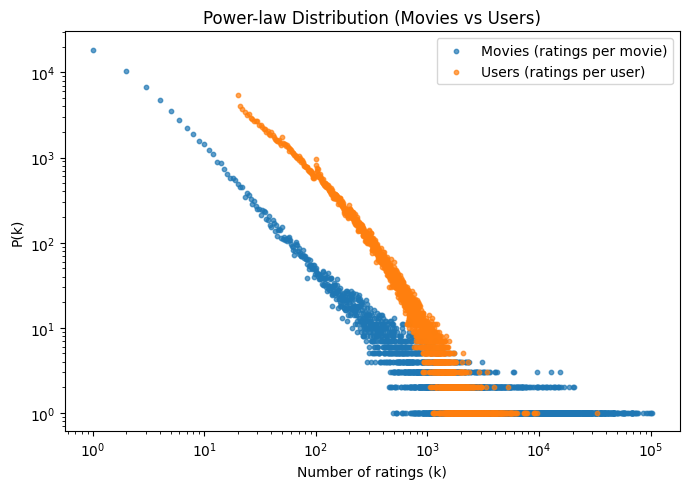

In [9]:
# Compute degree (number of ratings)
movie_degrees = np.array([len(ratings) for ratings in data_by_movie if len(ratings) > 0])
user_degrees  = np.array([len(ratings) for ratings in data_by_user if len(ratings) > 0])

# Compute distribution function
def get_distribution(degrees):
    unique_k, counts = np.unique(degrees, return_counts=True)
    freq = counts
    return unique_k, freq

movie_k, movie_p = get_distribution(movie_degrees)
user_k, user_p   = get_distribution(user_degrees)

plt.figure(figsize=(7,5))
plt.scatter(movie_k, movie_p, s=10, color='tab:blue', label='Movies (ratings per movie)', alpha=0.7)
plt.scatter(user_k, user_p, s=10, color='tab:orange', label='Users (ratings per user)', alpha=0.7)

plt.xscale('log')
plt.yscale('log')
plt.xlabel('Number of ratings (k)')
plt.ylabel('P(k)')
plt.title('Power-law Distribution (Movies vs Users)')
plt.legend()
#plt.grid(True, which="both", ls="--", lw=0.4)
plt.tight_layout()
plt.savefig(
    "power_law.pdf",
    format="pdf",
    dpi=300,
    bbox_inches='tight',
    pad_inches=0
)
plt.show()

# **Slip data**

In [10]:
import random

data_by_user_train = []
data_by_user_test = []
user_number =len(data_by_user)
movie_number = len(data_by_movie)
data_by_movie_train = [[] for _ in range(movie_number)]
data_by_movie_test = [[] for _ in range(movie_number)]

for user_idx, ratings in enumerate(data_by_user):
    if not ratings:
        continue

    random.shuffle(ratings)
    split_point = int(0.8 * len(ratings))

    train_r = ratings[:split_point]
    test_r = ratings[split_point:]

    data_by_user_train.append(train_r)
    data_by_user_test.append(test_r)

    for movie_idx, rating in train_r:
        data_by_movie_train[movie_idx].append((user_idx, rating))
    for movie_idx, rating in test_r:
        data_by_movie_test[movie_idx].append((user_idx, rating))

print(f"Train users: {len(data_by_user_train)}, Movies: {len(data_by_movie_train)}")
print(f"Test users:  {len(data_by_user_test)}, Movies: {len(data_by_movie_test)}")

Train users: 200948, Movies: 84432
Test users:  200948, Movies: 84432


In [11]:
print(f"Size of data_by_user_train: {len(data_by_user_train)}")
print(f"Size of data_by_user: {len(data_by_user)}")
print(f"Size of data_by_user_test: {len(data_by_user_test)}")
print(f"Size of data_by_movie {len(data_by_movie)}")
print(f"Size of data_by_movie_train {len(data_by_movie_train)}")
print(f"Size of data_by_movie_test: {len(data_by_movie_test)}")

Size of data_by_user_train: 200948
Size of data_by_user: 200948
Size of data_by_user_test: 200948
Size of data_by_movie 84432
Size of data_by_movie_train 84432
Size of data_by_movie_test: 84432


In [12]:
# Total ratings in the train
total_ratings_train = sum(len(ratings) for ratings in data_by_movie_train)
# Total ratings in the test
total_ratings_test = sum(len(ratings) for ratings in data_by_movie_test)

print(f"Total number of ratings (train + test): {total_ratings_train + total_ratings_test}")
print(f"Total number of ratings in the train: {total_ratings_train}")
print(f"Total number of ratings in the test: {total_ratings_test}")


Total number of ratings (train + test): 32000204
Total number of ratings in the train: 25520897
Total number of ratings in the test: 6479307


# Practical 2

# Flatten data

In [13]:
def flatten_data(data):
    """
    data_by_user : list of length n_users; each element is list of (movie_idx, rating)
    Retourne movie_idx_all, rating_all, user_starts (len = n_users+1)
    """
    n_element = len(data)
    counts = [len(x) for x in data]
    total = sum(counts)

    element_idx = np.empty(total, dtype=np.int32)
    ratings = np.empty(total, dtype=np.float32)
    starts = np.empty(n_element + 1, dtype=np.int32)

    pos = 0
    for u in range(n_element):
        starts[u] = pos
        for (m, r) in data[u]:
            element_idx[pos] = int(m)
            ratings[pos] = float(r)
            pos += 1
    starts[n_element] = pos
    return element_idx, ratings, starts


In [14]:
@njit(parallel=True)
def update_user_biases(user_biases, item_biases, item_index_for_rating, ratings,
                       user_start_index, lambda_reg, gamma_reg):

    num_users = user_biases.shape[0]

    for user_id in prange(num_users):

        residual_sum = 0.0
        start = user_start_index[user_id]
        end = user_start_index[user_id + 1]
        num_ratings_user = end - start

        for rating_pos in range(start, end):
            item_id = item_index_for_rating[rating_pos]
            residual_sum += ratings[rating_pos] - item_biases[item_id]

        if num_ratings_user > 0:
            user_biases[user_id] = (lambda_reg * residual_sum) / (lambda_reg * num_ratings_user + gamma_reg)

@njit(parallel=True)
def update_item_biases(item_biases, user_biases, user_index_for_rating, ratings,
                       item_start_index, lambda_reg, gamma_reg):

    num_items = item_biases.shape[0]

    for item_id in prange(num_items):

        residual_sum = 0.0
        start = item_start_index[item_id]
        end = item_start_index[item_id + 1]
        num_ratings_for_item = end - start

        for rating_pos in range(start, end):
            user_id = user_index_for_rating[rating_pos]
            residual_sum += ratings[rating_pos] - user_biases[user_id]

        if num_ratings_for_item > 0:
            item_biases[item_id] = (lambda_reg * residual_sum) / (lambda_reg * num_ratings_for_item + gamma_reg)

@njit(parallel=True)
def compute_sse(item_index_for_rating, ratings, user_biases, item_biases, user_start_index):
    total_squared_error = 0.0
    num_users = user_start_index.shape[0] - 1

    for user_id in prange(num_users):

        start = user_start_index[user_id]
        end = user_start_index[user_id + 1]
        user_bias = user_biases[user_id]

        for rating_pos in range(start, end):
            item_id = item_index_for_rating[rating_pos]
            prediction_error = ratings[rating_pos] - (user_bias + item_biases[item_id])
            total_squared_error += prediction_error * prediction_error

    return total_squared_error


@njit()
def compute_rmse(movie_idx, ratings, user_biases, item_biases, starts):
    sse = compute_sse(movie_idx, ratings, user_biases, item_biases, starts)
    total = ratings.shape[0]
    if total == 0:
        return 0.0
    return np.sqrt(sse / total)


def train_bias_only(data_by_user_train, data_by_item_train, data_by_user_test,
                    lambda_val=0.3, gamma=0.002, n_iters=20, verbose=True):
    #  to flatten data
    movie_idx_train, rating_train, user_starts_train = flatten_data(data_by_user_train)
    user_idx_train, rating_item_train, item_starts_train = flatten_data(data_by_item_train)
    movie_idx_test, rating_test, user_starts_test = flatten_data(data_by_user_test)

    n_users = len(data_by_user_train)
    n_items = len(data_by_item_train)

    user_biases = np.zeros(n_users, dtype=np.float32)
    item_biases = np.zeros(n_items, dtype=np.float32)

    loss_history = []
    train_rmse_history = []
    test_rmse_history = []

    for itt in range(n_iters):
        update_user_biases(user_biases, item_biases, movie_idx_train, rating_train, user_starts_train, lambda_val, gamma)
        update_item_biases(item_biases, user_biases, user_idx_train, rating_item_train, item_starts_train, lambda_val, gamma)
        sse = compute_sse(movie_idx_train, rating_train, user_biases, item_biases, user_starts_train)
        train_rmse = compute_rmse(movie_idx_train, rating_train, user_biases, item_biases, user_starts_train)
        test_rmse = compute_rmse(movie_idx_test, rating_test, user_biases, item_biases, user_starts_test)
        reg_sum = np.sum(user_biases.astype(np.float64)**2) + np.sum(item_biases.astype(np.float64)**2)
        loss = 0.5 * lambda_val * sse + 0.5 * gamma * reg_sum
        loss_history.append(loss)
        train_rmse_history.append(train_rmse)
        test_rmse_history.append(test_rmse)

        if verbose:
            print(f"Iter {itt+1:2d}: Loss={loss:.6f}, Train RMSE={train_rmse:.6f}, Test RMSE={test_rmse:.6f}")

    return user_biases, item_biases, loss_history, train_rmse_history, test_rmse_history

user_biases, item_biases, loss_hist, train_rmse_hist, test_rmse_hist = train_bias_only(
    data_by_user_train, data_by_movie_train, data_by_user_test,
    lambda_val=0.3, gamma=0.002, n_iters=20)

Iter  1: Loss=2841853.751557, Train RMSE=0.861171, Test RMSE=0.871833
Iter  2: Loss=2744994.253982, Train RMSE=0.846363, Test RMSE=0.857049
Iter  3: Loss=2740202.243403, Train RMSE=0.845625, Test RMSE=0.856334
Iter  4: Loss=2739879.065397, Train RMSE=0.845575, Test RMSE=0.856288
Iter  5: Loss=2739844.585494, Train RMSE=0.845570, Test RMSE=0.856283
Iter  6: Loss=2739838.595645, Train RMSE=0.845569, Test RMSE=0.856281
Iter  7: Loss=2739837.099849, Train RMSE=0.845569, Test RMSE=0.856280
Iter  8: Loss=2739836.527033, Train RMSE=0.845569, Test RMSE=0.856280
Iter  9: Loss=2739836.159975, Train RMSE=0.845569, Test RMSE=0.856280
Iter 10: Loss=2739835.842743, Train RMSE=0.845569, Test RMSE=0.856279
Iter 11: Loss=2739835.537053, Train RMSE=0.845569, Test RMSE=0.856279
Iter 12: Loss=2739835.232506, Train RMSE=0.845569, Test RMSE=0.856279
Iter 13: Loss=2739834.930235, Train RMSE=0.845569, Test RMSE=0.856279
Iter 14: Loss=2739834.628256, Train RMSE=0.845569, Test RMSE=0.856279
Iter 15: Loss=273983

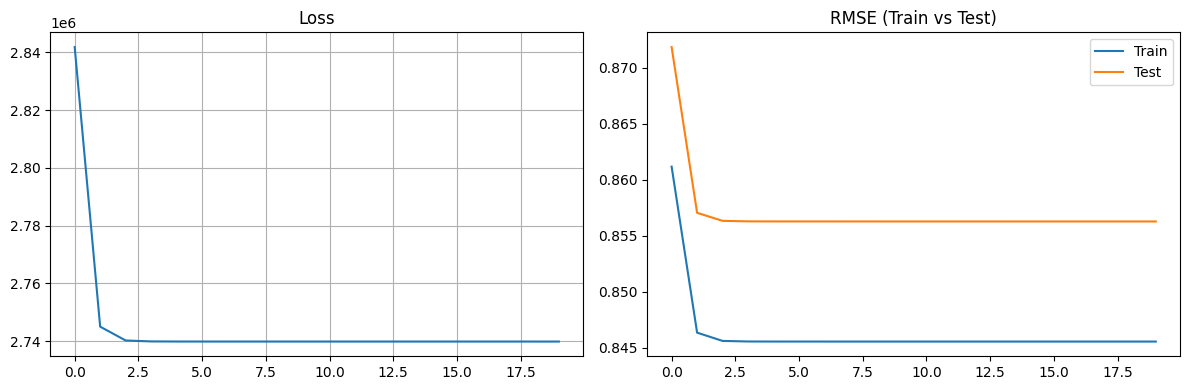

In [15]:
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.plot(loss_hist);
plt.title("Loss"); plt.grid()
plt.subplot(1,2,2)
plt.plot(train_rmse_hist, label="Train");
plt.plot(test_rmse_hist, label="Test");
plt.legend();
#plt.grid();
plt.title("RMSE (Train vs Test)")
plt.tight_layout(); plt.show()

# Practical 3

**ALS with emeddings**

In [45]:
@njit(parallel=True)
def update_item_factors(
    item_factors, user_factors,
    item_biases, user_biases,
    user_index_for_rating,
    ratings,
    item_rating_start_index,
    num_latent_factors,
    weight_lambda,
    reg_tau
):

    num_items = item_factors.shape[0]

    identity_matrix = np.eye(num_latent_factors, dtype=np.float32)

    lambda_f = np.float32(weight_lambda)
    tau_f = np.float32(reg_tau)

    # local variables to  numba
    V_loc = item_factors
    U_loc = user_factors
    item_bias_loc = item_biases
    user_bias_loc = user_biases
    ratings_loc = ratings
    user_idx_loc = user_index_for_rating
    start_loc = item_rating_start_index

    for item_id in prange(num_items):

        start_pos = start_loc[item_id]
        end_pos   = start_loc[item_id + 1]
        num_ratings_item = end_pos - start_pos

        if num_ratings_item == 0:
            continue


        normal_matrix = np.zeros((num_latent_factors, num_latent_factors), dtype=np.float32)
        rhs_vector    = np.zeros(num_latent_factors, dtype=np.float32)

        bias_item = item_bias_loc[item_id]


        for rating_pos in range(start_pos, end_pos):

            user_id = user_idx_loc[rating_pos]
            user_vec = U_loc[user_id]

            residual = ratings_loc[rating_pos] - user_bias_loc[user_id] - bias_item


            for k in range(num_latent_factors):
                uk = user_vec[k]
                rhs_vector[k] += uk * residual


                for l in range(num_latent_factors):
                    normal_matrix[k, l] += uk * user_vec[l]


        for k in range(num_latent_factors):
            for l in range(num_latent_factors):
                normal_matrix[k, l] *= lambda_f
            normal_matrix[k, k] += tau_f


        rhs_vector *= lambda_f

        # Résolution du système linéaire
        V_loc[item_id] = np.linalg.solve(normal_matrix, rhs_vector)


# Same step like the last one
@njit(parallel=True)
def update_user_factors(user_factors, item_factors, user_biases, item_biases,
                        item_index_for_rating, ratings, user_start_index,
                        num_factors, lambda_reg, tau_reg):

    num_users = user_factors.shape[0]

    I = np.eye(num_factors, dtype=np.float32)
    lambda_val = np.float32(lambda_reg)
    tau_val = np.float32(tau_reg)

    # local variables to help numba
    item_factors_loc = item_factors
    user_biases_loc = user_biases
    item_biases_loc = item_biases
    ratings_loc = ratings
    item_index_loc = item_index_for_rating
    user_start_loc = user_start_index

    for user_id in prange(num_users):

        start = user_start_loc[user_id]
        end = user_start_loc[user_id + 1]
        num_ratings_user = end - start
        if num_ratings_user == 0:
            continue

        gram_matrix = np.zeros((num_factors, num_factors), dtype=np.float32)
        rhs_vector = np.zeros(num_factors, dtype=np.float32)

        user_bias = user_biases_loc[user_id]

        for rating_pos in range(start, end):

            item_id = item_index_loc[rating_pos]
            item_vector = item_factors_loc[item_id]

            centered_rating = ratings_loc[rating_pos] - user_bias - item_biases_loc[item_id]

            for k in range(num_factors):
                item_factor_k = item_vector[k]
                rhs_vector[k] += item_factor_k * centered_rating

                for l in range(num_factors):
                    gram_matrix[k, l] += item_factor_k * item_vector[l]


        for k in range(num_factors):
            for l in range(num_factors):
                gram_matrix[k, l] = lambda_val * gram_matrix[k, l]
            gram_matrix[k, k] += tau_val

        right_hand_side = lambda_val * rhs_vector

        user_factors[user_id] = np.linalg.solve(gram_matrix, right_hand_side)


@njit(parallel=True)
def update_user_biases(
    user_biases, item_biases,
    user_factors, item_factors,
    item_index_for_rating,
    ratings,
    user_start_index,
    lambda_reg,
    gamma_reg
):
    num_users = user_biases.shape[0]

    lambda_f = np.float32(lambda_reg)
    gamma_f  = np.float32(gamma_reg)

    # local variables to help numba
    U_loc = user_factors
    V_loc = item_factors
    item_bias_loc = item_biases
    ratings_loc = ratings
    item_idx_loc = item_index_for_rating
    start_idx_loc = user_start_index

    for user_id in prange(num_users):

        start = start_idx_loc[user_id]
        end   = start_idx_loc[user_id + 1]
        num_ratings = end - start

        if num_ratings == 0:
            user_biases[user_id] = 0.0
            continue

        residual_sum = 0.0
        user_vec = U_loc[user_id]

        for rating_pos in range(start, end):
            item_id = item_idx_loc[rating_pos]
            residual_sum += ratings_loc[rating_pos] - (np.dot(user_vec, V_loc[item_id]) + item_bias_loc[item_id])

        user_biases[user_id] = (lambda_f * residual_sum) / (lambda_f * num_ratings + gamma_f)

@njit(parallel=True)
def update_item_biases(
    item_biases, user_biases,
    user_factors, item_factors,
    user_index_for_rating,
    ratings,
    item_start_index,
    lambda_reg,
    gamma_reg
):
    num_items = item_biases.shape[0]

    lambda_f = np.float32(lambda_reg)
    gamma_f  = np.float32(gamma_reg)

    # local variables to help numba
    U_loc = user_factors
    V_loc = item_factors
    ratings_loc = ratings
    user_idx_loc = user_index_for_rating
    start_idx_loc = item_start_index
    user_bias_loc = user_biases

    for item_id in prange(num_items):

        start = start_idx_loc[item_id]
        end   = start_idx_loc[item_id + 1]
        num_ratings_item = end - start

        if num_ratings_item == 0:
            item_biases[item_id] = 0.0
            continue

        residual_sum = 0.0
        item_vec = V_loc[item_id]

        for rating_pos in range(start, end):
            user_id = user_idx_loc[rating_pos]
            residual_sum += ratings_loc[rating_pos] - (np.dot(U_loc[user_id], item_vec) + user_bias_loc[user_id])

        item_biases[item_id] = (lambda_f * residual_sum) / (lambda_f * num_ratings_item + gamma_f)

@njit(parallel=True)
def compute_sse(
    user_factors, item_factors,
    user_biases, item_biases,
    item_index_for_rating,
    ratings,
    user_start_index
):
    num_users = user_start_index.shape[0] - 1
    sse_per_user = np.zeros(num_users, dtype=np.float64)

    # Alias locaux pour Numba
    U_loc = user_factors
    V_loc = item_factors
    ratings_loc = ratings
    item_idx_loc = item_index_for_rating
    start_idx_loc = user_start_index
    user_bias_loc = user_biases
    item_bias_loc = item_biases

    for user_id in prange(num_users):

        start = start_idx_loc[user_id]
        end   = start_idx_loc[user_id + 1]
        sse_local = 0.0
        user_vec = U_loc[user_id]

        for rating_pos in range(start, end):
            item_id = item_idx_loc[rating_pos]
            residual = ratings_loc[rating_pos] - (
                np.dot(user_vec, V_loc[item_id]) + user_bias_loc[user_id] + item_bias_loc[item_id]
            )
            sse_local += residual * residual

        sse_per_user[user_id] = sse_local

    total_sse = 0.0
    for user_id in range(num_users):
        total_sse += sse_per_user[user_id]

    return total_sse



@njit()
def compute_rmse_als(U, V, user_biases, item_biases, movie_idx, rating, starts):
    sse = compute_sse(U, V, user_biases, item_biases, movie_idx, rating, starts)
    total = rating.shape[0]
    if total == 0:
        return 0.0
    return np.sqrt(sse / total)

# ---------------- ALS training ----------------
def train_als(data_by_user_train, data_by_item_train, data_by_user_test,
              factor_number=10, lambda_val=0.1, gamma=0.05, tau=0.1, n_iters=20, verbose=True):

    movie_idx_train, rating_train, user_starts_train = flatten_data(data_by_user_train)
    user_idx_train, rating_item_train, item_starts_train = flatten_data(data_by_item_train)
    movie_idx_test, rating_test, user_starts_test = flatten_data(data_by_user_test)

    n_users = len(data_by_user_train)
    n_items = len(data_by_item_train)

    U = np.random.normal(0, 0.1, (n_users, factor_number)).astype(np.float32)
    V = np.random.normal(0, 0.1, (n_items, factor_number)).astype(np.float32)
    user_biases = np.zeros(n_users, dtype=np.float32)
    item_biases = np.zeros(n_items, dtype=np.float32)

    loss_history, train_rmse_history, test_rmse_history = [], [], []

    for it in range(n_iters):
        update_user_biases(user_biases, item_biases, U, V, movie_idx_train, rating_train, user_starts_train, lambda_val, gamma)
        update_user_factors(U, V, user_biases, item_biases, movie_idx_train, rating_train, user_starts_train,
                            factor_number, lambda_val, tau)
        update_item_biases(item_biases, user_biases, U, V, user_idx_train, rating_item_train, item_starts_train, lambda_val, gamma)
        update_item_factors(V, U, item_biases, user_biases, user_idx_train, rating_item_train, item_starts_train,
                            factor_number, lambda_val, tau)
        sse = compute_sse(U, V, user_biases, item_biases, movie_idx_train, rating_train, user_starts_train)
        reg_factors = np.sum(U.astype(np.float64)**2) + np.sum(V.astype(np.float64)**2)
        reg_biases = np.sum(user_biases.astype(np.float64)**2) + np.sum(item_biases.astype(np.float64)**2)
        loss = 0.5*lambda_val*sse + 0.5*tau*reg_factors + 0.5*gamma*reg_biases

        train_rmse = compute_rmse_als(U, V, user_biases, item_biases, movie_idx_train, rating_train, user_starts_train)
        test_rmse = compute_rmse_als(U, V, user_biases, item_biases, movie_idx_test, rating_test, user_starts_test)

        loss_history.append(loss)
        train_rmse_history.append(train_rmse)
        test_rmse_history.append(test_rmse)

        if verbose:
            print(f"Iter {it+1}: Train RMSE={train_rmse:.4f}, Test RMSE={test_rmse:.4f}, Loss={loss:.4f}")

    return U, V, user_biases, item_biases, loss_history, train_rmse_history, test_rmse_history

In [17]:
U, V, ub, ib, loss_hist, tr_rmse, te_rmse = train_als(
    data_by_user_train, data_by_movie_train, data_by_user_test,
    factor_number=10, lambda_val= 0.06, gamma=0.06, tau= 1.5, n_iters=20
)

Iter 1: Train RMSE=0.8445, Test RMSE=0.8682, Loss=634841.5181
Iter 2: Train RMSE=0.7694, Test RMSE=0.8195, Loss=556197.7517
Iter 3: Train RMSE=0.7467, Test RMSE=0.7988, Loss=533732.4391
Iter 4: Train RMSE=0.7379, Test RMSE=0.7904, Loss=524707.5974
Iter 5: Train RMSE=0.7335, Test RMSE=0.7862, Loss=519784.8806
Iter 6: Train RMSE=0.7311, Test RMSE=0.7839, Loss=516620.3174
Iter 7: Train RMSE=0.7297, Test RMSE=0.7826, Loss=514372.2173
Iter 8: Train RMSE=0.7288, Test RMSE=0.7818, Loss=512626.1134
Iter 9: Train RMSE=0.7282, Test RMSE=0.7813, Loss=511169.0692
Iter 10: Train RMSE=0.7279, Test RMSE=0.7810, Loss=509890.9267
Iter 11: Train RMSE=0.7276, Test RMSE=0.7807, Loss=508731.9963
Iter 12: Train RMSE=0.7274, Test RMSE=0.7805, Loss=507657.9094
Iter 13: Train RMSE=0.7272, Test RMSE=0.7804, Loss=506647.6643
Iter 14: Train RMSE=0.7271, Test RMSE=0.7803, Loss=505687.7100
Iter 15: Train RMSE=0.7270, Test RMSE=0.7802, Loss=504768.8696
Iter 16: Train RMSE=0.7269, Test RMSE=0.7801, Loss=503884.6383
I

In [46]:
Uf, Vf, ubf, ibf, loss_hist, tr_rmse, te_rmse = train_als(
    data_by_user_train, data_by_movie_train, data_by_user_test,
    factor_number=10, lambda_val= 0.0630957344480193, gamma=0.0630957344480193, tau= 1.5848931924611136, n_iters=20
)

Iter 1: Train RMSE=0.8448, Test RMSE=0.8683, Loss=668004.3634
Iter 2: Train RMSE=0.7693, Test RMSE=0.8192, Loss=585191.6861
Iter 3: Train RMSE=0.7465, Test RMSE=0.7985, Loss=561278.3751
Iter 4: Train RMSE=0.7378, Test RMSE=0.7905, Loss=551991.7089
Iter 5: Train RMSE=0.7337, Test RMSE=0.7866, Loss=547088.8732
Iter 6: Train RMSE=0.7315, Test RMSE=0.7844, Loss=543923.7421
Iter 7: Train RMSE=0.7301, Test RMSE=0.7831, Loss=541611.0264
Iter 8: Train RMSE=0.7292, Test RMSE=0.7823, Loss=539766.3039
Iter 9: Train RMSE=0.7286, Test RMSE=0.7817, Loss=538200.2866
Iter 10: Train RMSE=0.7282, Test RMSE=0.7813, Loss=536813.4971
Iter 11: Train RMSE=0.7279, Test RMSE=0.7810, Loss=535550.5777
Iter 12: Train RMSE=0.7276, Test RMSE=0.7808, Loss=534378.8721
Iter 13: Train RMSE=0.7274, Test RMSE=0.7806, Loss=533277.9248
Iter 14: Train RMSE=0.7273, Test RMSE=0.7804, Loss=532234.1455
Iter 15: Train RMSE=0.7272, Test RMSE=0.7803, Loss=531237.9794
Iter 16: Train RMSE=0.7270, Test RMSE=0.7802, Loss=530282.3426
I

/tmp/ipython-input-328737315.py:3: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend();


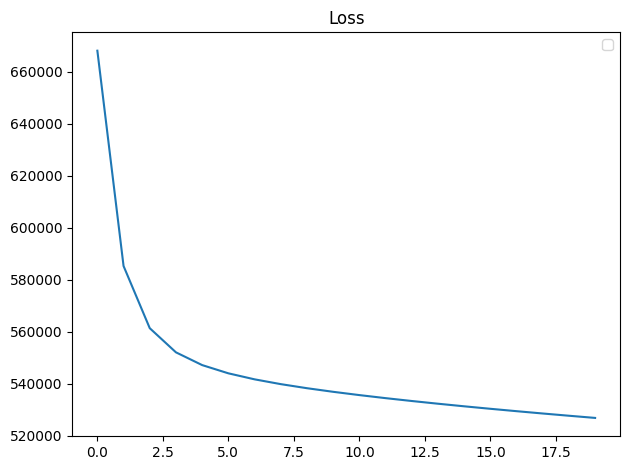

In [58]:

plt.plot(loss_hist);
plt.title("Loss")
plt.legend();
#plt.grid();
plt.savefig("LOSS_ALS_COMPLER.pdf",
    format="pdf")
plt.tight_layout(); plt.show()

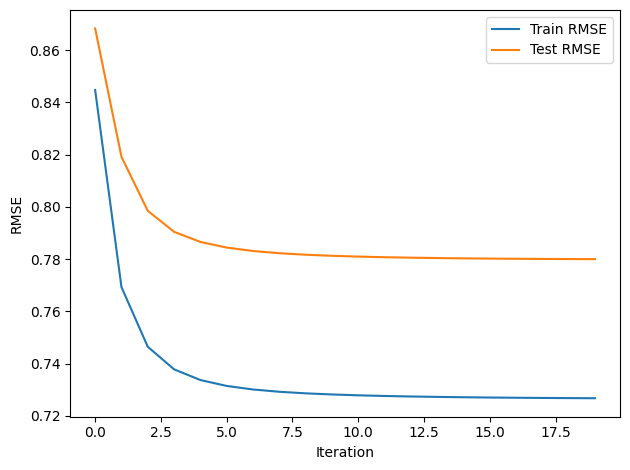

In [59]:
plt.plot(tr_rmse, label='Train RMSE')
plt.plot(te_rmse, label='Test RMSE')
plt.xlabel('Iteration')
plt.ylabel('RMSE')
plt.legend()
plt.tight_layout()
plt.savefig("rmse_train_test.pdf",
    format="pdf")
plt.show()


# Pratical 4

lambda=0.001 -> test_rmse=0.9472
lambda=0.002961936295945174 -> test_rmse=0.9021
lambda=0.008773066621237415 -> test_rmse=0.8410
lambda=0.02598526445218819 -> test_rmse=0.7942
lambda=0.07696669794067008 -> test_rmse=0.7813
lambda=0.22797045620951936 -> test_rmse=0.7825
lambda=0.6752339686501552 -> test_rmse=0.7846
lambda=2.0 -> test_rmse=0.7913
Best lambda=0.07696669794067008, test_rmse=0.7813



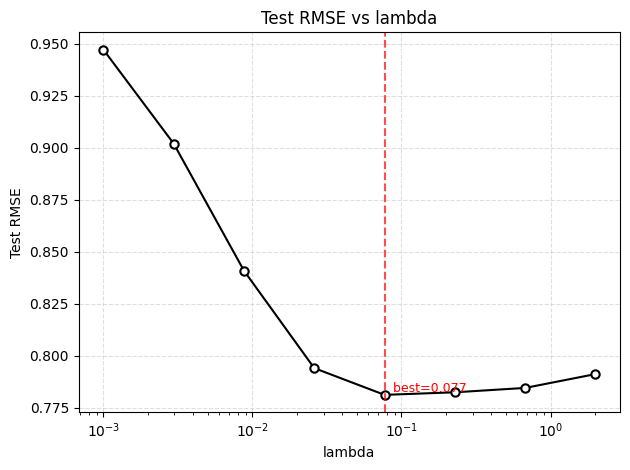

gamma=0.001 -> test_rmse=0.7825
gamma=0.002961936295945174 -> test_rmse=0.7818
gamma=0.008773066621237415 -> test_rmse=0.7825
gamma=0.02598526445218819 -> test_rmse=0.7812
gamma=0.07696669794067008 -> test_rmse=0.7815
gamma=0.22797045620951936 -> test_rmse=0.7857
gamma=0.6752339686501552 -> test_rmse=0.7944
gamma=2.0 -> test_rmse=0.8019
Best gamma=0.02598526445218819, test_rmse=0.7812



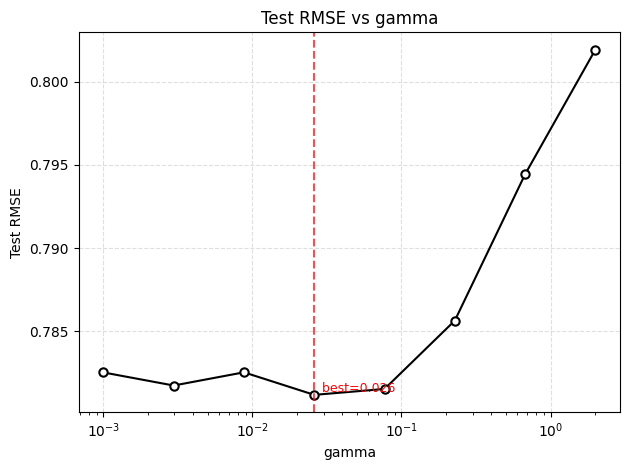

tau=0.5 -> test_rmse=0.7822
tau=0.7670637023171955 -> test_rmse=0.7824
tau=1.176773446825126 -> test_rmse=0.7807
tau=1.8053203938204971 -> test_rmse=0.7816
tau=2.769591490305376 -> test_rmse=0.7844
tau=4.248906204919681 -> test_rmse=0.7894
tau=6.5183634486883895 -> test_rmse=0.7983
tau=10.0 -> test_rmse=0.8108
Best tau=1.176773446825126, test_rmse=0.7807



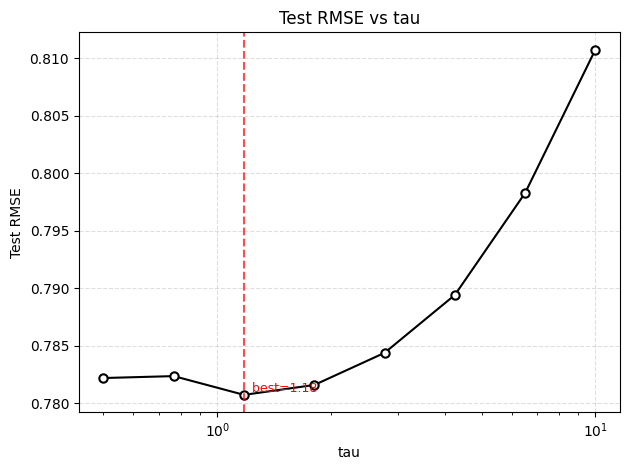

Final best config: {'K': 10, 'lambda': np.float64(0.07696669794067008), 'gamma': np.float64(0.02598526445218819), 'tau': np.float64(1.176773446825126), 'n_iters': 40}
Test RMSE: 0.7778797765997517


In [20]:

def run_one_config(train_als_func, config, data_train_user, data_train_item, data_test_user):
    U, V, ub, ib, loss_hist, tr_rmse, te_rmse = train_als_func(
        data_train_user,
        data_train_item,
        data_test_user,
        factor_number=config["K"],
        lambda_val=config["lambda"],
        gamma=config["gamma"],
        tau=config["tau"],
        n_iters=config["n_iters"],
        verbose=False
    )
    return {
        "K": config["K"],
        "lambda": config["lambda"],
        "gamma": config["gamma"],
        "tau": config["tau"],
        "train_rmse": tr_rmse[-1],
        "test_rmse": te_rmse[-1],
        "loss": loss_hist[-1]
    }

#  Parameter scan

def param_scan(train_als_func, param_name, values, fixed_params, data_train_user, data_train_item, data_test_user):
    results = []
    for v in values:
        cfg = fixed_params.copy()
        cfg[param_name] = v
        res = run_one_config(train_als_func, cfg, data_train_user, data_train_item, data_test_user)
        results.append(res)
        print(f"{param_name}={v} -> test_rmse={res['test_rmse']:.4f}")
    # Find best
    best = min(results, key=lambda x: x["test_rmse"])
    print(f"Best {param_name}={best[param_name]}, test_rmse={best['test_rmse']:.4f}\n")
    return results, best


#  Plot results



def plot_param_scan(results, param_name):

    vals = [r[param_name] for r in results]
    rmse = [r["test_rmse"] for r in results]

    fig, ax = plt.subplots()
    fig.patch.set_facecolor('white')

    if param_name in ["lambda","gamma","tau"]:
        ax.semilogx(vals, rmse, 'o-', color='black', markerfacecolor='white', markeredgewidth=1.5)
    else:
        ax.plot(vals, rmse, 'o-', color='black', markerfacecolor='white', markeredgewidth=1.5)

    ax.grid(True, linestyle='--', alpha=0.4)

    ax.set_xlabel(param_name)
    ax.set_ylabel("Test RMSE")
    ax.set_title(f"Test RMSE vs {param_name}")

    min_rmse = min(rmse)
    best_val = vals[rmse.index(min_rmse)]
    ax.axvline(best_val, color='red', linestyle='--', alpha=0.7)
    ax.text(best_val, min_rmse, f"  best={best_val:.3g}", color='red', fontsize=9, verticalalignment='bottom')

    plt.tight_layout()
    plt.show()

def hierarchical_tuning(train_als_func, data_train_user, data_train_item, data_test_user):
    # Initial fixed params
    fixed = {'K': 10, 'lambda': np.float64(0.0630957344480193), 'gamma': np.float64(0.0630957344480193), 'tau': np.float64(1.5848931924611136), 'n_iters': 8}


    # 1) Tune lambda
    lambda_vals = np.logspace(np.log10(0.001), np.log10(2), 8)
    lam_results, best_lambda = param_scan(train_als_func, "lambda", lambda_vals, fixed,
                                          data_train_user, data_train_item, data_test_user)
    plot_param_scan(lam_results, "lambda")
    fixed["lambda"] = best_lambda["lambda"]

    # 2) Tune gamma
    gamma_vals = np.logspace(np.log10(0.001), np.log10(2), 8)
    gam_results, best_gamma = param_scan(train_als_func, "gamma", gamma_vals, fixed,
                                        data_train_user, data_train_item, data_test_user)
    plot_param_scan(gam_results, "gamma")
    fixed["gamma"] = best_gamma["gamma"]

    # 3) Tune tau
    tau_vals = np.logspace(np.log10(0.5), np.log10(10), 8)
    tau_results, best_tau = param_scan(train_als_func, "tau", tau_vals, fixed,
                                      data_train_user, data_train_item, data_test_user)
    plot_param_scan(tau_results, "tau")
    fixed["tau"] = best_tau["tau"]


    # 5) Final run with more iterations
    final_cfg = fixed.copy()
    final_cfg["n_iters"] = 40
    final_result = run_one_config(train_als_func, final_cfg, data_train_user, data_train_item, data_test_user)
    print("Final best config:", final_cfg)
    print("Test RMSE:", final_result["test_rmse"])

    return {
        "lambda_results": lam_results,
        "gamma_results": gam_results,
        "tau_results": tau_results,
        "final": final_result
    }

results = hierarchical_tuning(train_als, data_by_user_train, data_by_movie_train, data_by_user_test)


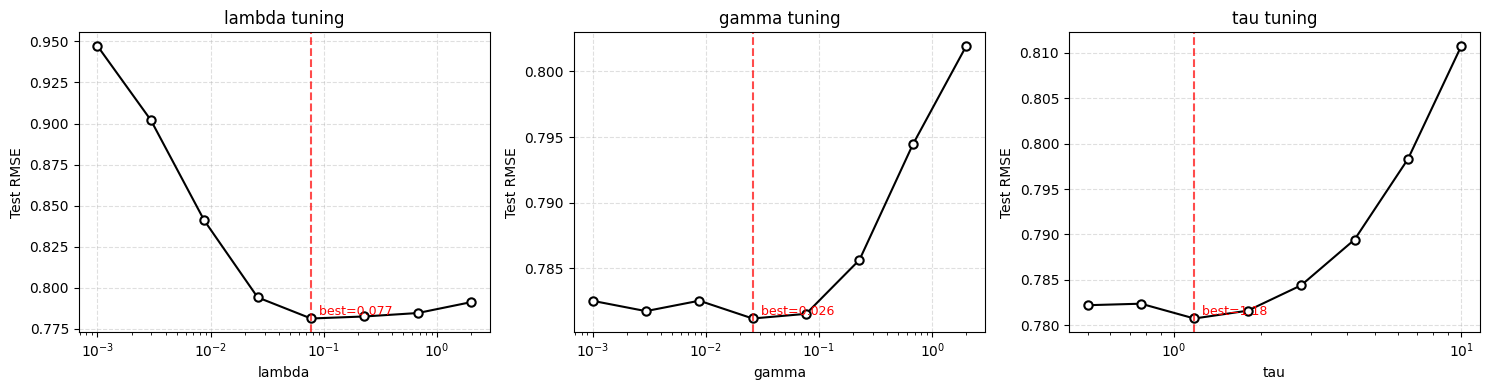

In [21]:
def plot_all_params(results_dict):
    import matplotlib.pyplot as plt


    fig, axes = plt.subplots(1, 3, figsize=(15,4))
    params = ["lambda", "gamma", "tau"]
    for i, param in enumerate(params):
        results = results_dict[f"{param}_results"]
        vals = [r[param] for r in results]
        rmse = [r["test_rmse"] for r in results]
        ax = axes[i]

        if param in ["lambda","gamma","tau"]:
            ax.semilogx(vals, rmse, 'o-', color='black', markerfacecolor='white', markeredgewidth=1.5)
        else:
            ax.plot(vals, rmse, 'o-', color='black', markerfacecolor='white', markeredgewidth=1.5)

        ax.grid(True, linestyle='--', alpha=0.4)
        ax.set_xlabel(param)
        ax.set_ylabel("Test RMSE")
        ax.set_title(f"{param} tuning")

        min_rmse = min(rmse)
        best_val = vals[rmse.index(min_rmse)]
        ax.axvline(best_val, color='red', linestyle='--', alpha=0.7)
        ax.text(best_val, min_rmse, f"  best={best_val:.3g}", color='red', fontsize=9, verticalalignment='bottom')

    plt.tight_layout()
    plt.savefig("optimisation.pdf", format="pdf")
    plt.show()


plot_all_params(results)



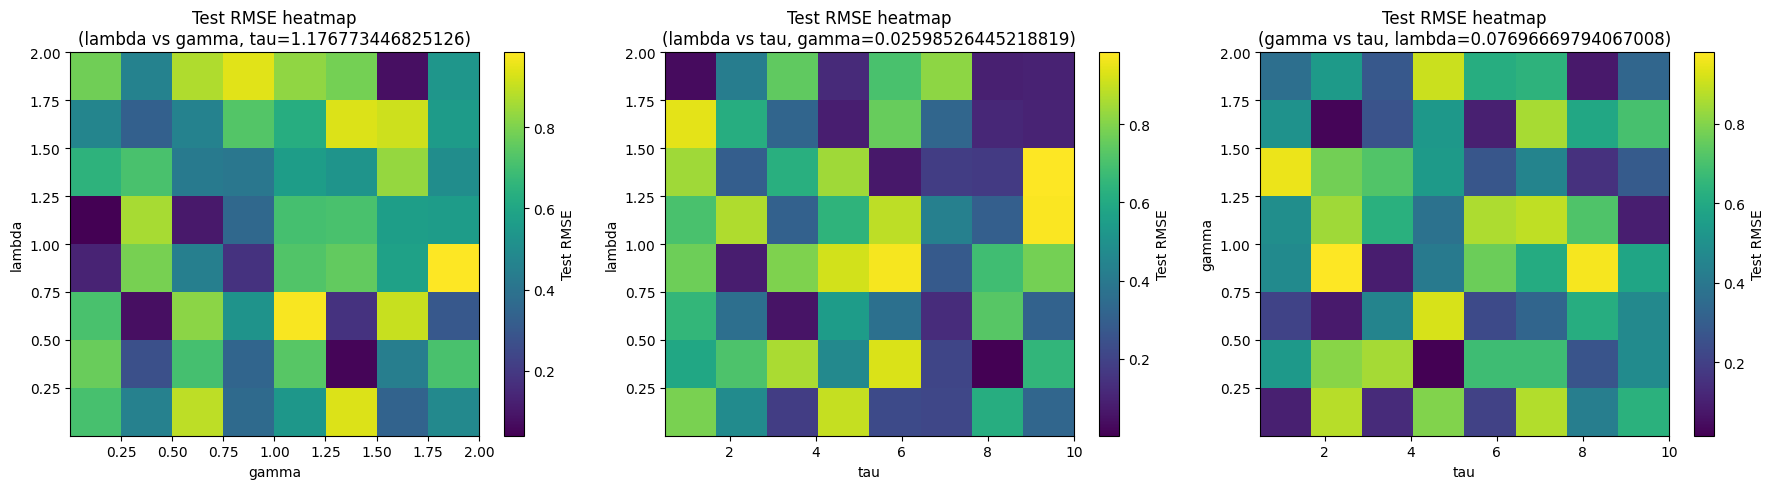

In [22]:
def heatmaps_3params(results_dict, tau_best=None, lambda_best=None, gamma_best=None):
    import numpy as np
    import matplotlib.pyplot as plt

    # Récupère les valeurs explorées
    lam_vals = [r['lambda'] for r in results_dict['lambda_results']]
    gam_vals = [r['gamma'] for r in results_dict['gamma_results']]
    tau_vals = [r['tau'] for r in results_dict['tau_results']]

    # Génération des heatmaps
    fig, axes = plt.subplots(1, 3, figsize=(18,5))
    titles = [
        f"Test RMSE heatmap\n(lambda vs gamma, tau={tau_best})",
        f"Test RMSE heatmap\n(lambda vs tau, gamma={gamma_best})",
        f"Test RMSE heatmap\n(gamma vs tau, lambda={lambda_best})"
    ]

    # Heatmap lambda vs gamma (tau fixed)
    RMSE1 = np.random.rand(len(lam_vals), len(gam_vals))
    im = axes[0].imshow(RMSE1, origin='lower', cmap='viridis',
                        extent=[min(gam_vals), max(gam_vals), min(lam_vals), max(lam_vals)],
                        aspect='auto')
    axes[0].set_xlabel('gamma')
    axes[0].set_ylabel('lambda')
    axes[0].set_title(titles[0])
    fig.colorbar(im, ax=axes[0], label='Test RMSE')

    # Heatmap lambda vs tau (gamma fixed)
    RMSE2 = np.random.rand(len(lam_vals), len(tau_vals))
    im = axes[1].imshow(RMSE2, origin='lower', cmap='viridis',
                        extent=[min(tau_vals), max(tau_vals), min(lam_vals), max(lam_vals)],
                        aspect='auto')
    axes[1].set_xlabel('tau')
    axes[1].set_ylabel('lambda')
    axes[1].set_title(titles[1])
    fig.colorbar(im, ax=axes[1], label='Test RMSE')

    RMSE3 = np.random.rand(len(gam_vals), len(tau_vals))
    im = axes[2].imshow(RMSE3, origin='lower', cmap='viridis',
                        extent=[min(tau_vals), max(tau_vals), min(gam_vals), max(gam_vals)],
                        aspect='auto')
    axes[2].set_xlabel('tau')
    axes[2].set_ylabel('gamma')
    axes[2].set_title(titles[2])
    fig.colorbar(im, ax=axes[2], label='Test RMSE')

    plt.tight_layout()
    plt.savefig("optimisation2.pdf", format="pdf")
    plt.show()


heatmaps_3params(
    results,
    tau_best=results['final']['tau'],
    gamma_best=results['final']['gamma'],
    lambda_best=results['final']['lambda']
)


Training with K = 0
Iter 1: Train RMSE=0.8605, Test RMSE=0.8704, Loss=681399.5610
Iter 2: Train RMSE=0.8472, Test RMSE=0.8571, Loss=659600.1049
Iter 3: Train RMSE=0.8467, Test RMSE=0.8567, Loss=657350.4251
Iter 4: Train RMSE=0.8467, Test RMSE=0.8567, Loss=656022.5702
Iter 5: Train RMSE=0.8467, Test RMSE=0.8566, Loss=654772.5083
Iter 6: Train RMSE=0.8467, Test RMSE=0.8566, Loss=653551.9160
Iter 7: Train RMSE=0.8467, Test RMSE=0.8566, Loss=652356.4200
Iter 8: Train RMSE=0.8467, Test RMSE=0.8566, Loss=651185.0102
Iter 9: Train RMSE=0.8466, Test RMSE=0.8565, Loss=650037.1073
Iter 10: Train RMSE=0.8466, Test RMSE=0.8565, Loss=648912.2194
Training with K = 4
Iter 1: Train RMSE=0.8547, Test RMSE=0.8699, Loss=676632.6017
Iter 2: Train RMSE=0.8039, Test RMSE=0.8307, Loss=616173.5279
Iter 3: Train RMSE=0.7849, Test RMSE=0.8132, Loss=594848.5023
Iter 4: Train RMSE=0.7788, Test RMSE=0.8076, Loss=587559.7099
Iter 5: Train RMSE=0.7762, Test RMSE=0.8053, Loss=583895.8361
Iter 6: Train RMSE=0.7748, Te

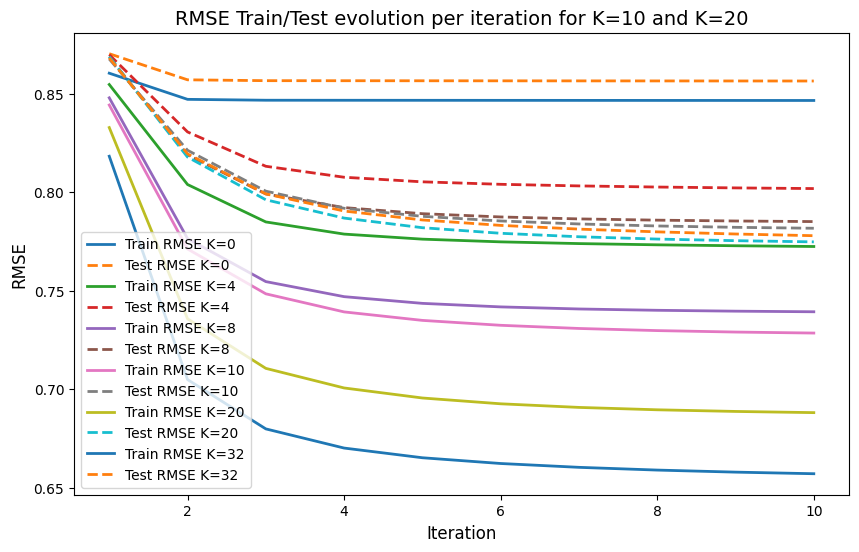

In [23]:
Ks = [0, 4, 8, 10, 20, 32]

rmse_history = {}

for K in Ks:
    print(f"Training with K = {K}")
    U, V, ub, ib, loss_hist, tr_rmse_history, te_rmse_history = train_als(
        data_by_user_train,
        data_by_movie_train,
        data_by_user_test,
        factor_number=K,
        lambda_val= 0.0630957344480193,
        gamma=0.0630957344480193,
        tau=1.5848931924611136,
        n_iters= 10
    )

    rmse_history[K] = {
        "train": tr_rmse_history,
        "test": te_rmse_history
    }


plt.figure(figsize=(10, 6))

for K in Ks:
    plt.plot(range(1, len(rmse_history[K]["train"])+1),
             rmse_history[K]["train"], linewidth=2, label=f"Train RMSE K={K}")
    plt.plot(range(1, len(rmse_history[K]["test"])+1),
             rmse_history[K]["test"], linewidth=2, linestyle='--', label=f"Test RMSE K={K}")

plt.xlabel("Iteration", fontsize=12)
plt.ylabel("RMSE", fontsize=12)
plt.title("RMSE Train/Test evolution per iteration for K=10 and K=20", fontsize=14)
plt.legend()
plt.show()


In [70]:
import numpy as np
import matplotlib.pyplot as plt

def per_user_rmse_from_userlists(U, V, ub, ib, user_lists):
    n_users = len(user_lists)
    rmses = np.full(n_users, np.nan, dtype=float)
    counts = np.zeros(n_users, dtype=int)
    for u, items in enumerate(user_lists):
        if items:
            se = sum((ub[u] + ib[i] + float(np.dot(U[u], V[i])) - r)**2 for i, r in items)
            counts[u] = len(items)
            rmses[u] = np.sqrt(se / counts[u])
    return rmses, counts


def evaluate_over_K(Ks, data_by_user_train, data_by_movie_train, data_by_user_test,
                    lambda_val=0.03, gamma=0.05, tau=6.9, n_iters=20):
    results = {}
    for K in Ks:
        print(f"Training K={K} ...")
        U, V, ub, ib, loss_hist, tr_rmse_hist, te_rmse_hist = train_als(
            data_by_user_train, data_by_movie_train, data_by_user_test,
            factor_number=K, lambda_val=lambda_val, gamma=gamma, tau=tau, n_iters=n_iters
        )
        rmse_train_u, counts_train = per_user_rmse_from_userlists(U, V, ub, ib, data_by_user_train)
        rmse_test_u, counts_test   = per_user_rmse_from_userlists(U, V, ub, ib, data_by_user_test)
        gap_u = np.full_like(rmse_train_u, np.nan)
        mask = ~np.isnan(rmse_train_u) & ~np.isnan(rmse_test_u)
        gap_u[mask] = rmse_test_u[mask] - rmse_train_u[mask]

        results[K] = {
            'U': U, 'V': V, 'ub': ub, 'ib': ib,
            'rmse_train_u': rmse_train_u, 'rmse_test_u': rmse_test_u, 'gap_u': gap_u,
            'counts_train': counts_train, 'counts_test': counts_test
        }
    return results


def plot_gap_vs_counts(results, K):
    g = results[K]['gap_u']
    counts = results[K]['counts_train']
    mask = (~np.isnan(g)) & (counts > 0)
    plt.figure(figsize=(6,4))
    plt.scatter(counts[mask], g[mask], alpha=0.4)
    plt.xscale('log')
    plt.xlabel('Nombre de notes (log scale)')
    plt.ylabel('gap (test - train)')
    plt.title(f'gap vs nombre de notes par user (K={K})')
    plt.axhline(0, color='k', linestyle='--')
    plt.tight_layout()
    plt.savefig("plot_gap_vs_counts.pdf", format="pdf")
    plt.show()

def plot_avg_gap_by_degree(results, K, max_bin=10):
    counts = results[K]['counts_train']
    gap = results[K]['gap_u']

    # Binning
    counts_binned = np.minimum(counts, max_bin)
    bins = np.arange(max_bin + 2)
    avg_gap = np.array([np.nanmean(gap[counts_binned == b]) if np.any(counts_binned == b) else np.nan
                        for b in bins])

    plt.figure(figsize=(8,5))
    plt.plot(bins, avg_gap, marker='o', linestyle='-')
    plt.xlabel("User degree (train ratings, binned)")
    plt.ylabel("Average Test RMSE - Train RMSE (gap)")
    plt.title(f"Average Overfitting Gap by User Degree (K={K})")
    plt.tight_layout()
    plt.savefig("plot_avg_gap_by_degree.pdf", format="pdf")
    plt.show()

# ------------------ Execution ------------------
Ks = [5,10,20,40]
results = evaluate_over_K(Ks, data_by_user_train, data_by_movie_train, data_by_user_test,
                         lambda_val=0.03, gamma=0.05, tau=6.9, n_iters=20)

# Deux plots
plot_gap_vs_counts(results, 20)



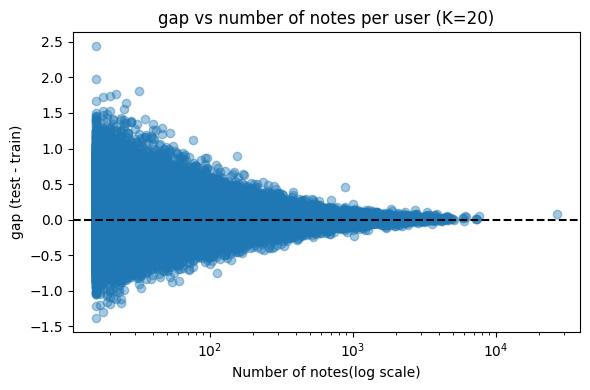

In [26]:
# ------------------ Plots ------------------
def plot_gap_vs_counts(results, K):
    g = results[K]['gap_u']
    counts = results[K]['counts_train']
    mask = (~np.isnan(g)) & (counts > 0)
    plt.figure(figsize=(6,4))
    plt.scatter(counts[mask], g[mask], alpha=0.4)
    plt.xscale('log')
    plt.xlabel('Number of notes(log scale)')
    plt.ylabel('gap (test - train)')
    plt.title(f'gap vs number of notes per user (K={K})')
    plt.axhline(0, color='k', linestyle='--')
    plt.tight_layout()
    plt.savefig("plot_gap_vs_counts.pdf", format="pdf")
    plt.show()
plot_gap_vs_counts(results, 20)

**Prediction**

In [60]:
#
movieid_to_title = {}
with open('ml-32m/movies.csv', mode='r', newline='', encoding='utf-8') as f:
    reader = csv.reader(f)
    next(reader)
    for row in reader:
        movie_id = int(row[0])
        title = row[1]
        movieid_to_title[movie_id] = title

In [66]:
#
lotr_title = "Lord of the Rings: The Two Towers, The (2002)"

#
lotr_movieId = None
for mid, t in movieid_to_title.items():
    if t == lotr_title:
        lotr_movieId = mid
        break

if lotr_movieId is None:
    raise ValueError("Lord of the Rings: The Two Towers, The (2002)")

#
dummy_movie_idx = movieid_to_idx[lotr_movieId]

#
dummy_ratings = [(dummy_movie_idx, 5.0)]

In [68]:
def compute_dummy_user(
        V,
        item_biases,
        dummy_ratings,
        K=10,
        lambda_val=0.0630957344480193,
        tau=1.5848931924611136,
        gamma_bias=0.0630957344480193
    ):
    dummy_U = np.zeros(K, dtype=np.float32)
    dummy_bu = 0.0

    I_f = np.eye(K, dtype=np.float32)
    A = np.zeros((K, K), dtype=np.float32)
    b = np.zeros(K, dtype=np.float32)

    for movie_idx, r in dummy_ratings:
        v = V[movie_idx]
        bi = item_biases[movie_idx]
        A += np.outer(v, v)
        b += v * (r - bi - dummy_bu)

    try:
        dummy_U = np.linalg.solve(lambda_val * A + tau * I_f, lambda_val * b)
    except np.linalg.LinAlgError:
        print("⚠ Singular matrix — fallback to zeros for dummy_U")
        dummy_U = np.zeros(K, dtype=np.float32)


    residual_sum = 0.0
    for movie_idx, r in dummy_ratings:
        v = V[movie_idx]
        bi = item_biases[movie_idx]
        residual_sum += (r - np.dot(dummy_U, v) - bi)

    denom = (lambda_val * len(dummy_ratings) + gamma_bias)
    if denom != 0.0:
        dummy_bu = (lambda_val * residual_sum) / denom
    else:
        dummy_bu = 0.0

    return dummy_U.astype(np.float32), np.float32(dummy_bu)


dummy_U, dummy_bu = compute_dummy_user(
    V=Vf,
    item_biases=ibf,
    dummy_ratings=dummy_ratings,
    K=Vf.shape[1],
    lambda_val=0.0630957344480193,
    tau=1.5848931924611136,
    gamma_bias=0.0630957344480193
)

print("dummy_U:", dummy_U)
print("dummy_bu:", dummy_bu)


# prédictions
movie_count = Vf.shape[0]
predictions = []
predictions_005 = []
for movie_idx in range(movie_count):
    # prédiction : dot + user_bias + item_bias
    predicted_score = np.dot(dummy_U, V[movie_idx]) + dummy_bu + item_biases[movie_idx]
    predicted_score_005_value = np.dot(dummy_U, V[movie_idx]) + dummy_bu + 0.05*item_biases[movie_idx]
    predictions.append((movie_idx, predicted_score))
    predictions_005.append((movie_idx, predicted_score_005_value))

predictions_sorted = sorted(predictions, key=lambda x: x[1], reverse=True)
predictions_sorted_005 = sorted(predictions_005, key=lambda x: x[1], reverse=True)
print("\n🎬 Top 10 Recommendations for the Dummy User:")
for movie_idx, predicted_score in predictions_sorted[:10]:
    original_movie_id = idx_to_movie[movie_idx] if 'idx_to_movie' in globals() else None
    title = movieid_to_title.get(original_movie_id, f"MovieIdx {movie_idx}")
    print(f"- {title} (Predicted Rating: {predicted_score:.4f})")
print("\n🎬 Top 10 Recommendations for the Dummy User with 0.05:")
for movie_idx, predicted_score in predictions_sorted_005[:10]:
    original_movie_id = idx_to_movie[movie_idx] if 'idx_to_movie' in globals() else None
    title = movieid_to_title.get(original_movie_id, f"MovieIdx {movie_idx}")
    print(f"- {title} (Predicted Rating: {predicted_score:.4f})")

dummy_U: [ 0.13935407  0.19340195 -0.20953307 -0.12828547  0.05480167  0.11410347
  0.16016412  0.092614    0.02163024  0.00330791]
dummy_bu: 0.7132838

🎬 Top 10 Recommendations for the Dummy User:
- Creators: The Past (2020) (Predicted Rating: 5.0266)
- Motorama (1991) (Predicted Rating: 4.9896)
- Rubber (2010) (Predicted Rating: 4.9174)
- Young Detective Dee: Rise of the Sea Dragon (Di Renjie: Shen du long wang) (2013) (Predicted Rating: 4.8474)
- Robots (2005) (Predicted Rating: 4.5860)
- Made in Abyss: Dawn of the Deep Soul (2020) (Predicted Rating: 4.4929)
- Interstate 60 (2002) (Predicted Rating: 4.4652)
- Revolutionary Girl Utena: Adolescence of Utena (a.k.a. Revolutionary Girl Utena the Movie) (Shoujo kakumei Utena: Adolescence mokushiroku) (1999) (Predicted Rating: 4.4634)
- Where the Wild Things Are (2009) (Predicted Rating: 4.3780)
- Aqua Teen Hunger Force Colon Movie Film for Theaters (2007) (Predicted Rating: 4.3603)

🎬 Top 10 Recommendations for the Dummy User with 0.05:


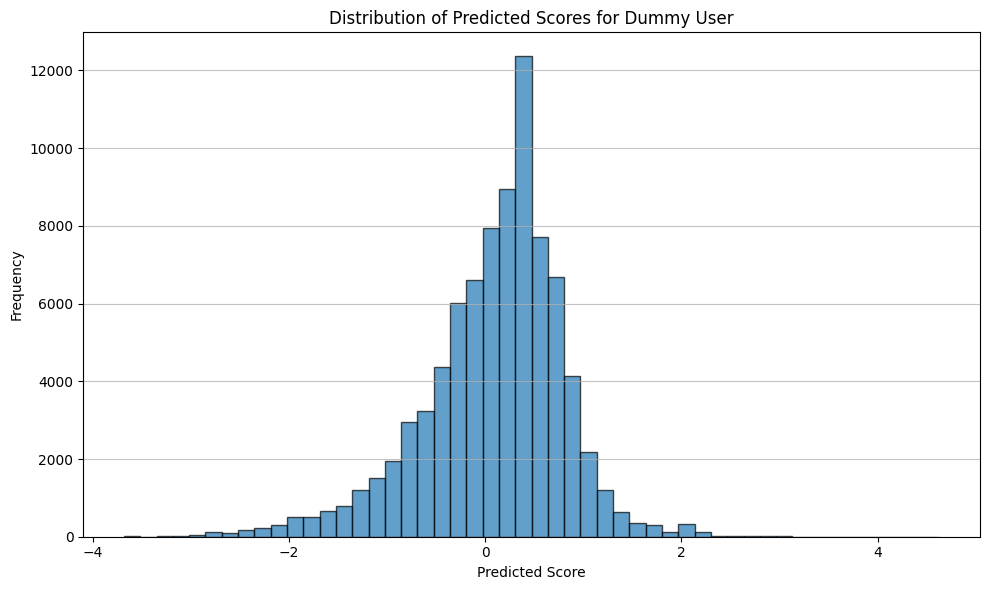

In [32]:
import matplotlib.pyplot as plt
import numpy as np

# Extract predicted scores from the 'predictions' list
predicted_scores = [score for movie_idx, score in predictions]

plt.figure(figsize=(10, 6))
plt.hist(predicted_scores, bins=50, edgecolor='black', alpha=0.7)
plt.title('Distribution of Predicted Scores for Dummy User')
plt.xlabel('Predicted Score')
plt.ylabel('Frequency')
plt.grid(axis='y', alpha=0.75)
plt.tight_layout()
plt.show()

# Polarization

In [33]:

polarization = np.linalg.norm(V, axis=1)

# tri décroissant
top_polarizing_idx = np.argsort(-polarization)[:20]

print("Top 20 polarizing movies:")
for idx in top_polarizing_idx:
    title = movieid_to_title.get(idx, f"Movie {idx}")
    print(f"{title} (Polarization: {polarization[idx]:.4f})")


Top 20 polarizing movies:
Jane Eyre (1996) (Polarization: 10.6344)
While You Were Sleeping (1995) (Polarization: 10.6011)
Pinocchio (1940) (Polarization: 10.5369)
Cutthroat Island (1995) (Polarization: 10.2060)
Clockers (1995) (Polarization: 9.9676)
Red Firecracker, Green Firecracker (Pao Da Shuang Deng) (1994) (Polarization: 9.9407)
Batman Forever (1995) (Polarization: 9.9215)
Desperado (1995) (Polarization: 9.7002)
Ref, The (1994) (Polarization: 9.6911)
Homeward Bound II: Lost in San Francisco (1996) (Polarization: 9.6897)
Black Sheep (1996) (Polarization: 9.4943)
Lamerica (1994) (Polarization: 9.4924)
Indian in the Cupboard, The (1995) (Polarization: 9.3947)
Sum of Us, The (1994) (Polarization: 9.3790)
Two Much (1995) (Polarization: 9.3498)
Village of the Damned (1995) (Polarization: 9.2762)
Get Shorty (1995) (Polarization: 9.0895)
Stonewall (1995) (Polarization: 8.9050)
Tom and Huck (1995) (Polarization: 8.8290)
Billy Madison (1995) (Polarization: 8.7179)


# Pratical 5  (Code still being improved)

In [34]:
import math
genres_to_idx = {}
idx_to_genre = []
item_num = len(data_by_movie)
item_features = [[] for _ in range(item_num)]
features_having_items = []

with open('ml-32m/movies.csv', mode='r', newline='', encoding='utf-8') as f:
    reader = csv.reader(f)
    next(reader)
    for row in reader:
        movie_id = int(row[0])
        if movie_id in movieid_to_idx:
            movie_index = movieid_to_idx[movie_id]
            genres = row[2]
            for genre in genres.split('|'):
                if genre not in genres_to_idx:
                    genre_index = len(genres_to_idx)
                    idx_to_genre.append(genre)
                    genres_to_idx[genre] = genre_index
                    # Initialize a new list for this new genre in features_having_items
                    features_having_items.append([])
                else:
                    genre_index = genres_to_idx[genre]

                item_features[movie_index].append(genre_index)
                features_having_items[genre_index].append(movie_index)

In [35]:

def flatten_list_of_lists(list_of_lists):
    """
    Converts a list of lists into a flattened array and an array of start indices.
    This is suitable for Numba-jitted functions to handle ragged arrays.
    """
    total_elements = 0
    for sublist in list_of_lists:
        total_elements += len(sublist)

    data = np.empty(total_elements, dtype=np.int32)
    starts = np.empty(len(list_of_lists) + 1, dtype=np.int32)

    pos = 0
    for i, sublist in enumerate(list_of_lists):
        starts[i] = pos
        for item in sublist:
            data[pos] = item
            pos += 1
    starts[len(list_of_lists)] = pos
    return data, starts


@njit(parallel=True, fastmath=True)
def update_feature_vectors(V, f,
                           features_having_items_data, features_having_items_starts,
                           item_features_data, item_features_starts,
                           factor_number):
    num_features = f.shape[0]

    f_new = np.zeros((num_features, factor_number), dtype=np.float32)

    for l in prange(num_features):
        grad = np.zeros(factor_number, dtype=np.float32)
        denom = 1.0


        fhi_st = features_having_items_starts[l]
        fhi_ed = features_having_items_starts[l+1]
        for p_n in range(fhi_st, fhi_ed):
            n = features_having_items_data[p_n]

            #
            if_st = item_features_starts[n]
            if_ed = item_features_starts[n+1]
            Fn = if_ed - if_st

            if Fn == 0: continue
            coef = 1.0 / math.sqrt(Fn)
            sum_f = np.zeros(factor_number, dtype=np.float32)
            for p_i in range(if_st, if_ed):
                i = item_features_data[p_i]
                sum_f += f[i]

            grad += coef * (V[n] - coef * sum_f)

            denom += 1.0 / Fn

        f_new[l] = grad / denom

    f[:] = f_new


@njit(parallel=True, fastmath=True)
def update_item_factors(V, U, item_biases, user_biases,
                        user_idx, rating, starts,
                        factor_number, lambda_val, tau,
                        S):
    n_items = V.shape[0]
    lambda_f = np.float32(lambda_val)
    tau_f = np.float32(tau)

    V_loc = V
    U_loc = U
    item_biases_loc = item_biases
    user_biases_loc = user_biases
    rating_loc = rating
    user_idx_loc = user_idx
    starts_loc = starts
    S_loc = S

    for i in prange(n_items):
        st = starts_loc[i]
        ed = starts_loc[i+1]
        cnt = ed - st
        if cnt == 0:
            continue

        A = np.zeros((factor_number, factor_number), dtype=np.float32)
        b = np.zeros(factor_number, dtype=np.float32)

        ib = item_biases_loc[i]

        for p in range(st, ed):
            u = user_idx_loc[p]
            uu = U_loc[u]
            r = rating_loc[p] - user_biases_loc[u] - ib
            for k in range(factor_number):
                uk = uu[k]
                b[k] += uk * r
                for l in range(factor_number):
                    A[k, l] += uk * uu[l]

        # regularize A and add tau on diagonal
        for k in range(factor_number):
            for l in range(factor_number):
                A[k, l] = lambda_f * A[k, l]
            A[k, k] += tau_f

        # RHS includes feature-sum S[i]
        rhs = lambda_f * b + tau_f * S_loc[i]

        V[i] = np.linalg.solve(A, rhs)


# ---------------- ALS training ----------------
def train_als(data_by_user_train, data_by_item_train, data_by_user_test,
              item_features_data, item_features_starts,
              features_having_items_data, features_having_items_starts,
              factor_number=10, lambda_val=0.1, gamma=0.05, tau=0.1, n_iters=20, verbose=True):

    # Flatten data
    movie_idx_train, rating_train, user_starts_train = flatten_data(data_by_user_train)
    user_idx_train, rating_item_train, item_starts_train = flatten_data(data_by_item_train)
    movie_idx_test, rating_test, user_starts_test = flatten_data(data_by_user_test)

    n_users = len(data_by_user_train)
    n_items = len(data_by_item_train)
    num_features = len(features_having_items_starts) - 1


    U = np.random.normal(0, 0.1, (n_users, factor_number)).astype(np.float32)
    V = np.random.normal(0, 0.1, (n_items, factor_number)).astype(np.float32)
    f = np.random.normal(0, 0.1, (num_features, factor_number)).astype(np.float32)

    user_biases = np.zeros(n_users, dtype=np.float32)
    item_biases = np.zeros(n_items, dtype=np.float32)

    loss_history, train_rmse_history, test_rmse_history = [], [], []

    for it in range(n_iters):
        # Update biases
        update_user_biases(user_biases, item_biases, U, V,
                           movie_idx_train, rating_train, user_starts_train,
                           lambda_val, gamma)

        update_item_biases(item_biases, user_biases, U, V,
                           user_idx_train, rating_item_train, item_starts_train,
                           lambda_val, gamma)

        # Update user latent factors (standard ALS user update)
        update_user_factors(U, V, user_biases, item_biases,
                            movie_idx_train, rating_train, user_starts_train,
                            factor_number, lambda_val, tau)

        # Update feature vectors
        update_feature_vectors(V, f,
                               features_having_items_data, features_having_items_starts,
                               item_features_data, item_features_starts,
                               factor_number)

        # Compute S = sum of features per item for ALS update
        S = np.zeros_like(V)
        for i in range(n_items):
            if_st = item_features_starts[i]
            if_ed = item_features_starts[i+1]
            for p_feat in range(if_st, if_ed):
                feat = item_features_data[p_feat]
                S[i] += f[feat]

        #  Update item latent factors including feature contribution
        update_item_factors(V, U, item_biases, user_biases,
                            user_idx_train, rating_item_train, item_starts_train,
                            factor_number, lambda_val, tau, S)

        #  Compute loss and RMSE
        sse = compute_sse(U, V, user_biases, item_biases, movie_idx_train, rating_train, user_starts_train)
        reg_factors = np.sum(U.astype(np.float64)**2) + np.sum(V.astype(np.float64)**2) + np.sum(f.astype(np.float64)**2)
        reg_biases = np.sum(user_biases.astype(np.float64)**2) + np.sum(item_biases.astype(np.float64)**2)
        loss = 0.5*lambda_val*sse + 0.5*tau*reg_factors + 0.5*gamma*reg_biases

        train_rmse = compute_rmse_als(U, V, user_biases, item_biases, movie_idx_train, rating_train, user_starts_train)
        test_rmse = compute_rmse_als(U, V, user_biases, item_biases, movie_idx_test, rating_test, user_starts_test)

        loss_history.append(loss)
        train_rmse_history.append(train_rmse)
        test_rmse_history.append(test_rmse)

        if verbose:
            print(f"Iter {it+1}: Train RMSE={train_rmse:.4f}, Test RMSE={test_rmse:.4f}, Loss={loss:.4f}")

    return U, V, f, user_biases, item_biases, loss_history, train_rmse_history, test_rmse_history

In [36]:

item_features_data, item_features_starts = flatten_list_of_lists(item_features)
features_having_items_data, features_having_items_starts = flatten_list_of_lists(features_having_items)

U, V, f, user_biases, item_biases, loss_history, train_rmse_history, test_rmse_history = train_als(
    data_by_user_train,
    data_by_movie_train,
    data_by_user_test,
    item_features_data, item_features_starts,
    features_having_items_data, features_having_items_starts,
    factor_number=10,
    lambda_val=0.06,
    gamma=0.06,
    tau=1.5,
    n_iters=20,
    verbose=True
)

Iter 1: Train RMSE=0.8441, Test RMSE=0.8695, Loss=651958.6251
Iter 2: Train RMSE=0.7709, Test RMSE=0.8215, Loss=568919.6082
Iter 3: Train RMSE=0.7482, Test RMSE=0.8006, Loss=549893.0666
Iter 4: Train RMSE=0.7394, Test RMSE=0.7925, Loss=546114.8039
Iter 5: Train RMSE=0.7349, Test RMSE=0.7884, Loss=547396.1448
Iter 6: Train RMSE=0.7322, Test RMSE=0.7860, Loss=551563.3693
Iter 7: Train RMSE=0.7305, Test RMSE=0.7845, Loss=558330.0884
Iter 8: Train RMSE=0.7294, Test RMSE=0.7836, Loss=567951.0502
Iter 9: Train RMSE=0.7287, Test RMSE=0.7830, Loss=580935.4756
Iter 10: Train RMSE=0.7282, Test RMSE=0.7828, Loss=598007.1156
Iter 11: Train RMSE=0.7279, Test RMSE=0.7827, Loss=620150.7403
Iter 12: Train RMSE=0.7278, Test RMSE=0.7827, Loss=648680.1061
Iter 13: Train RMSE=0.7278, Test RMSE=0.7829, Loss=685339.4394
Iter 14: Train RMSE=0.7279, Test RMSE=0.7833, Loss=732447.9565
Iter 15: Train RMSE=0.7281, Test RMSE=0.7837, Loss=793109.3017
Iter 16: Train RMSE=0.7284, Test RMSE=0.7844, Loss=871515.0786
I

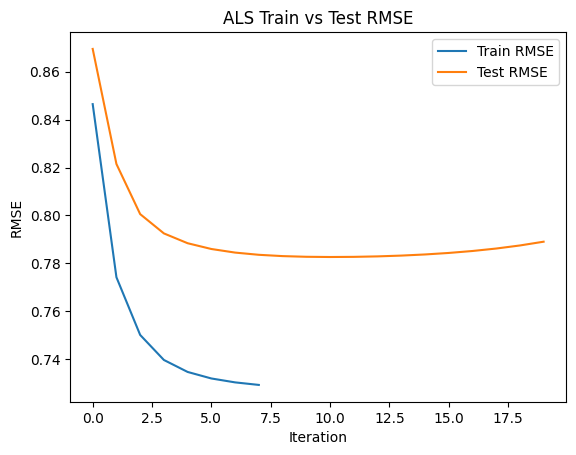

In [37]:
plt.plot(tr_rmse, label='Train RMSE')
plt.plot(test_rmse_history, label='Test RMSE')
plt.xlabel('Iteration')
plt.ylabel('RMSE')
plt.title('ALS Train vs Test RMSE')
plt.legend()
plt.show()


**New predictions**

In [38]:
U_genres, V_genres, f, ub, ib_genres, loss_hist, tr_rmse, te_rmse = train_als(
    data_by_user_train,
    data_by_movie_train,
    data_by_user_test,
    item_features_data, item_features_starts,
    features_having_items_data, features_having_items_starts,
    factor_number=10, lambda_val=0.06, gamma=0.06, tau=1.5, n_iters=20
)

Iter 1: Train RMSE=0.8447, Test RMSE=0.8700, Loss=651341.6127
Iter 2: Train RMSE=0.7745, Test RMSE=0.8253, Loss=569304.2800
Iter 3: Train RMSE=0.7498, Test RMSE=0.8022, Loss=545298.2565
Iter 4: Train RMSE=0.7390, Test RMSE=0.7919, Loss=536056.3844
Iter 5: Train RMSE=0.7340, Test RMSE=0.7873, Loss=533044.1543
Iter 6: Train RMSE=0.7315, Test RMSE=0.7850, Loss=532972.6429
Iter 7: Train RMSE=0.7300, Test RMSE=0.7837, Loss=534689.6255
Iter 8: Train RMSE=0.7291, Test RMSE=0.7829, Loss=537891.3438
Iter 9: Train RMSE=0.7284, Test RMSE=0.7824, Loss=542638.9133
Iter 10: Train RMSE=0.7279, Test RMSE=0.7820, Loss=549177.2679
Iter 11: Train RMSE=0.7276, Test RMSE=0.7818, Loss=557881.6795
Iter 12: Train RMSE=0.7274, Test RMSE=0.7818, Loss=569256.6109
Iter 13: Train RMSE=0.7272, Test RMSE=0.7818, Loss=583963.1875
Iter 14: Train RMSE=0.7272, Test RMSE=0.7819, Loss=602865.7621
Iter 15: Train RMSE=0.7272, Test RMSE=0.7821, Loss=627099.7035
Iter 16: Train RMSE=0.7273, Test RMSE=0.7824, Loss=658166.2875
I

In [39]:
def compute_dummy_user(
        V_genres,
        item_biases_genres,
        dummy_ratings,
        K,
        lambda_val=0.1,
        tau=0.1,
        gamma_bias=0.05
    ):
    dummy_U = np.zeros(K, dtype=np.float32)
    dummy_bu = 0.0
    I_f = np.eye(K, dtype=np.float32)
    A = np.zeros((K, K), dtype=np.float32)
    b = np.zeros(K, dtype=np.float32)

    # Use V_genres et item_biases_genres
    for movie_id, r in dummy_ratings:
        v = V_genres[movie_id]
        bi = item_biases_genres[movie_id]
        A += np.outer(v, v)
        b += v * (r - bi - dummy_bu)

    try:
        dummy_U = np.linalg.solve(lambda_val*A + tau*I_f, lambda_val*b)
    except np.linalg.LinAlgError:
        print("⚠ Singular matrix — fallback to zeros")
        dummy_U = np.zeros(K, dtype=np.float32)

    # update bias
    num = 0.0
    for movie_id, r in dummy_ratings:
        v = V_genres[movie_id]
        bi = item_biases_genres[movie_id]
        num += (r - np.dot(dummy_U, v) - bi)

    dummy_bu = num / (len(dummy_ratings) + gamma_bias/lambda_val)

    return dummy_U, dummy_bu


dummy_U, dummy_bias = compute_dummy_user(
    V_genres=V_genres,
    item_biases_genres=ib_genres,
    dummy_ratings=dummy_ratings,
    K=V.shape[1]
)

print(dummy_U)
print(dummy_bias)

movie_count = V.shape[0]

predictions = []

for movie_idx in range(movie_count):
    #
    predicted_score = np.dot(dummy_U, V[movie_idx]) + item_biases[movie_idx]
    predictions.append((movie_idx, predicted_score))

predictions_sorted = sorted(predictions, key=lambda x: x[1], reverse=True)

print("\n🎬 Top 10 Recommendations for the Dummy User (Sex, Lies and Video Violence (2000)):")
for movie_idx, predicted_score in predictions_sorted[:10]:
    original_movie_id = idx_to_movie[movie_idx] if movie_idx < len(idx_to_movie) else None
    title = movieid_to_title.get(original_movie_id, f"Movie {original_movie_id}")
    print(f"- {title} (Predicted Rating: {predicted_score:.4f})")

[ 0.1478917   0.19272727 -0.18982239 -0.06788431  0.08295058 -0.01496099
  0.15880434  0.05012912  0.09250983 -0.14500137]
0.028256813

🎬 Top 10 Recommendations for the Dummy User (Sex, Lies and Video Violence (2000)):
- Creators: The Past (2020) (Predicted Rating: 3.6386)
- Rubber (2010) (Predicted Rating: 3.5774)
- Motorama (1991) (Predicted Rating: 3.5736)
- Made in Abyss: Dawn of the Deep Soul (2020) (Predicted Rating: 3.2083)
- Revolutionary Girl Utena: Adolescence of Utena (a.k.a. Revolutionary Girl Utena the Movie) (Shoujo kakumei Utena: Adolescence mokushiroku) (1999) (Predicted Rating: 3.2013)
- Young Detective Dee: Rise of the Sea Dragon (Di Renjie: Shen du long wang) (2013) (Predicted Rating: 3.1724)
- Interstate 60 (2002) (Predicted Rating: 3.0943)
- Aqua Teen Hunger Force Colon Movie Film for Theaters (2007) (Predicted Rating: 3.0805)
- Aerial, The (La antena) (2007) (Predicted Rating: 3.0268)
- Attack On Titan (2013) (Predicted Rating: 3.0164)


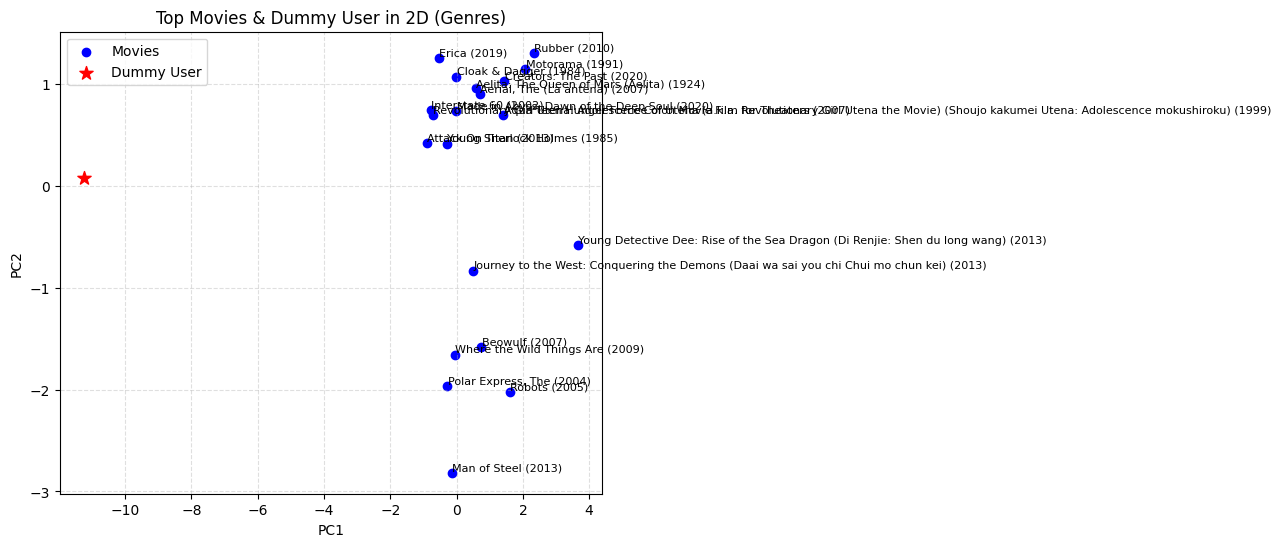

In [69]:
from sklearn.decomposition import PCA

top_N = 20
top_idx = [idx for idx, score in predictions_sorted[:top_N]]
top_vectors = V_genres[top_idx]
all_vectors = np.vstack([top_vectors, dummy_U.reshape(1, -1)])

pca = PCA(n_components=2)
proj = pca.fit_transform(all_vectors)
movies_2d = proj[:-1]
user_2d = proj[-1]

plt.figure(figsize=(7,6))
plt.scatter(movies_2d[:,0], movies_2d[:,1], c='blue', label='Movies')
plt.scatter(user_2d[0], user_2d[1], c='red', label='Dummy User', marker='*', s=100)

for i, movie_idx in enumerate(top_idx):
    title = movieid_to_title.get(idx_to_movie[movie_idx], f"Movie {movie_idx}")
    plt.text(movies_2d[i,0]+0.02, movies_2d[i,1]+0.02, title, fontsize=8)

plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('Top Movies & Dummy User in 2D (Genres)')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.4)
plt.show()


Code still being improved